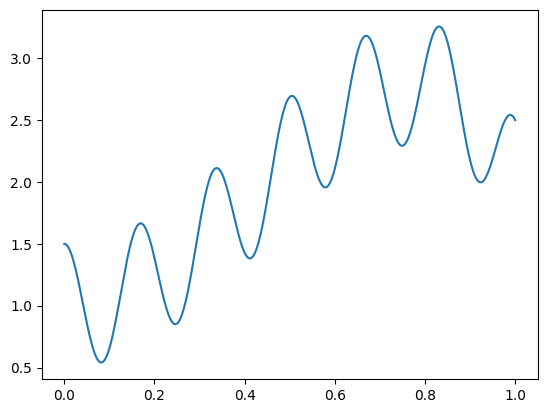

In [15]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch

# pyro.set_rng_seed(98728292)


def g(x):
    return -(torch.sin(6 * np.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


def gen_data():
    l = 30
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + np.sqrt(0.01) * torch.randn(len(x))
    permutation = torch.randperm(len(x))
    x_shuffle = x[permutation]
    y_shuffle = y[permutation]
    x_train = x_shuffle[:20]
    y_train = y_shuffle[:20]
    x_eval = x_shuffle[20:]
    y_eval = y_shuffle[20:]
    return x_train, y_train, x_eval, y_eval


def log_likelihood(x, y, params):
    rbf = gp.kernels.RBF(input_dim=1, variance=params[1], lengthscale=params[0])
    periodic = gp.kernels.Periodic(
        input_dim=1, period=params[3], lengthscale=params[2], variance=params[4]
    )
    kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
    noise_y = params[5]
    n = len(y)
    K = kernel.forward(x)
    like1 = -1 / 2 * y @ torch.linalg.inv(noise_y * torch.eye(n) + K) @ y
    like2 = -1 / 2 * torch.log(torch.linalg.det(noise_y * torch.eye(n) + K))
    like3 = -n / 2 * torch.log(2 * torch.tensor(np.pi))
    return like1 + like2 + like3


def approximate_log_likelihood(x, y, posterior_samples):
    log_likelihoods = []
    for rbf_l, rbf_v, per_l, per_p, per_v, noise in zip(
        posterior_samples["kernel.kern0.lengthscale"],
        posterior_samples["kernel.kern0.variance"],
        posterior_samples["kernel.kern1.lengthscale"],
        posterior_samples["kernel.kern1.period"],
        posterior_samples["kernel.kern1.variance"],
        posterior_samples["noise"],
    ):
        # print(rbf_l, rbf_v, per_l, per_p, per_v, noise)
        log_likelihoods.append(
            log_likelihood(x, y, [rbf_l, rbf_v, per_l, per_p, per_v, noise])
        )
    return torch.tensor(log_likelihoods).mean()


# Plot of data generating function
xs = torch.linspace(0, 1.0, 500)
ys = g(xs)
plt.plot(xs, ys)


In [16]:
x_train, y_train, x_test, y_test = gen_data()

# Defining our kernels and GP-model
rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
)
periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(0.5),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(1.0),
)
kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Putting priors on our kernel parameters
gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.Exponential(4.0))
gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))


nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=1000)
mcmc.run()


Warmup [1]:   0%|          | 0/1500 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1500 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


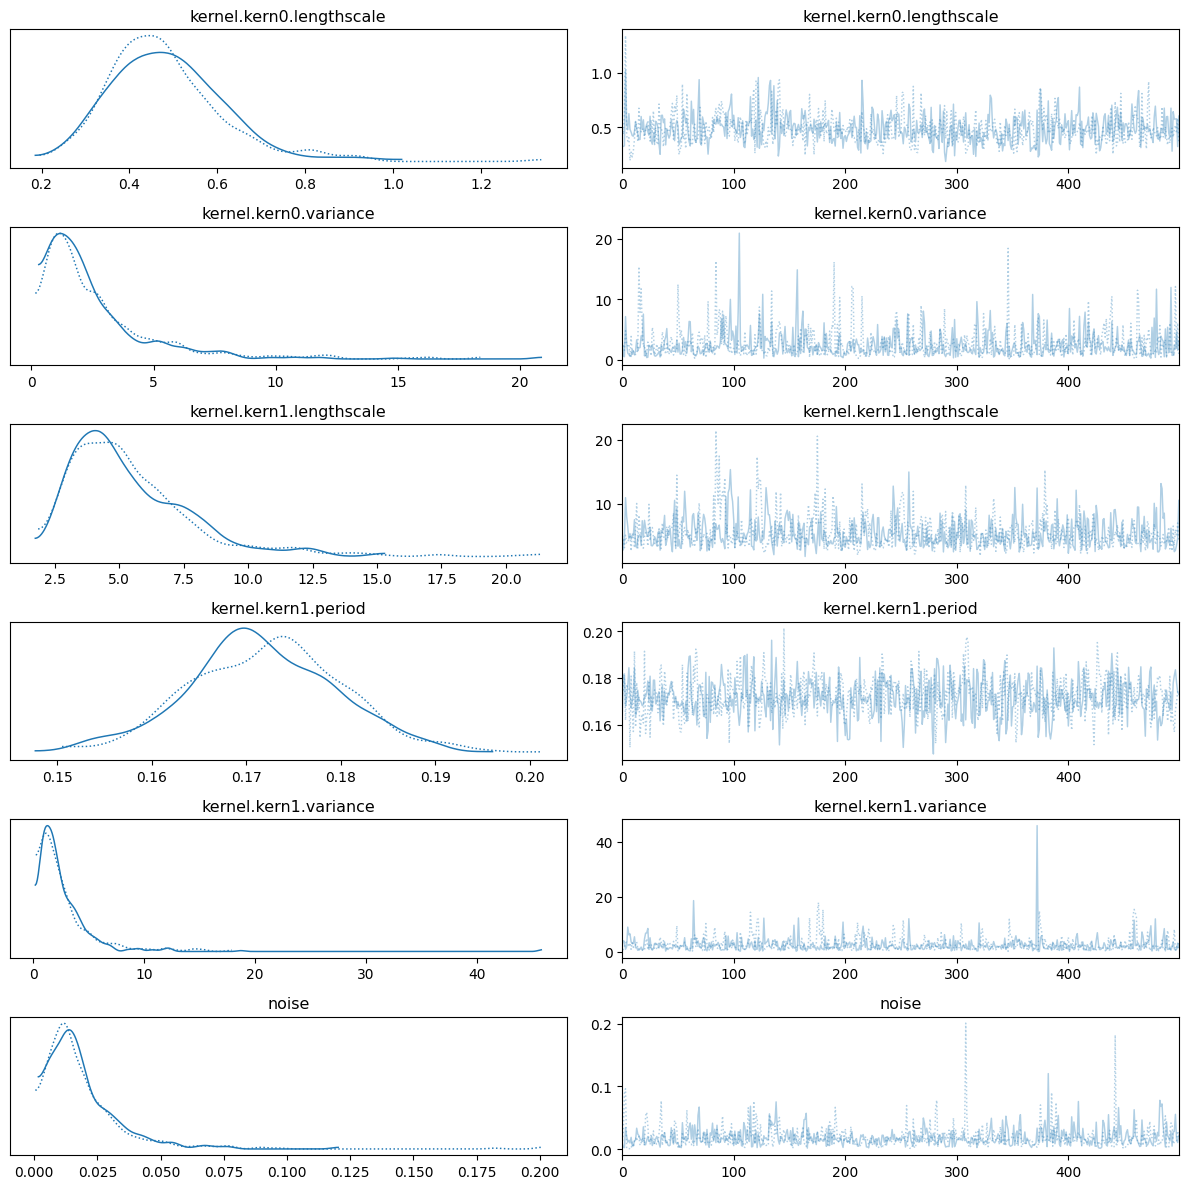

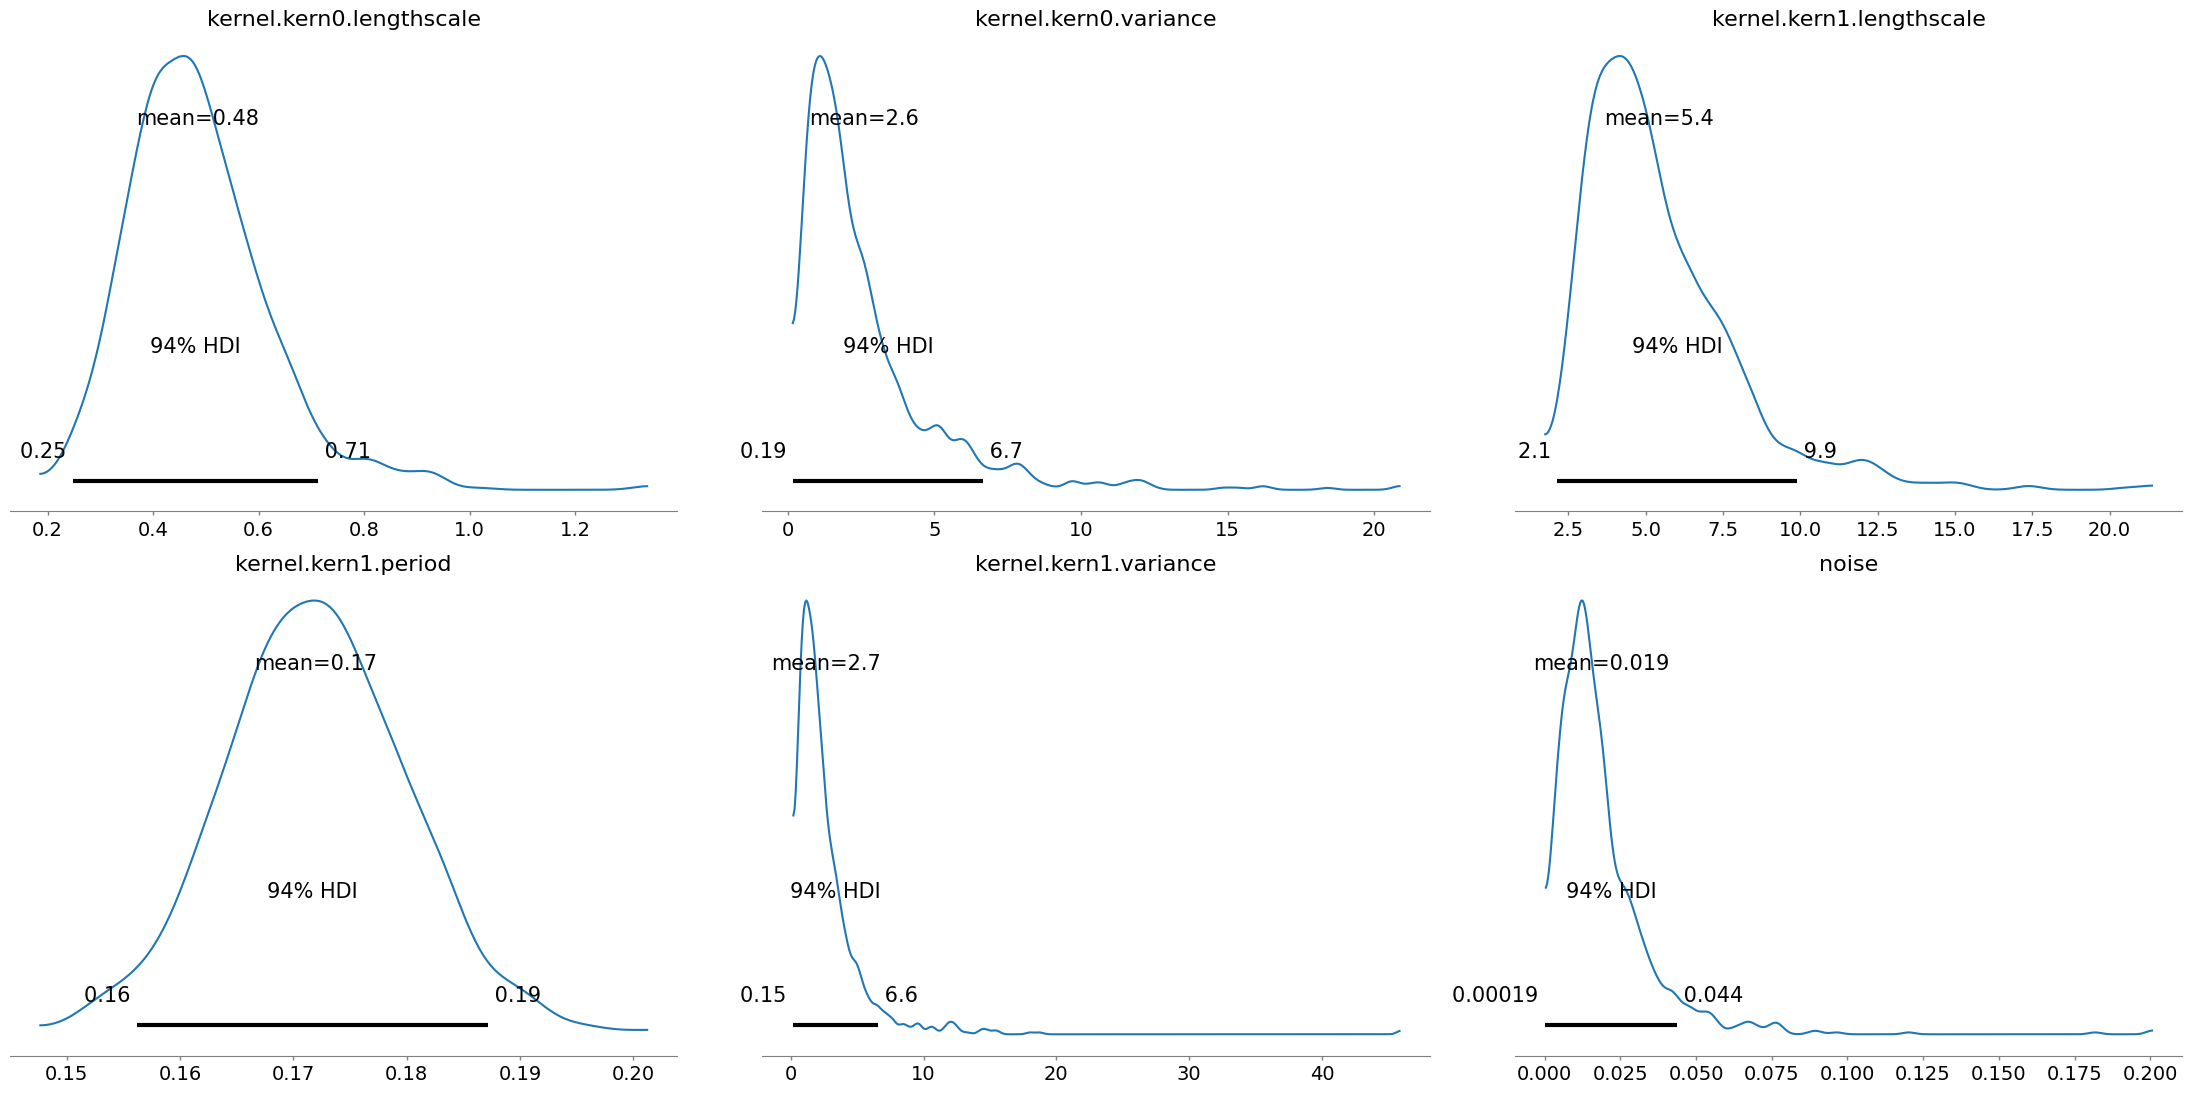

In [17]:
arviz_data = az.from_pyro(mcmc)
az.plot_trace(arviz_data)
plt.tight_layout()
plt.savefig("arviz_trace.png", dpi=400)
az.plot_posterior(arviz_data)
plt.tight_layout()
plt.savefig("arviz_posterior.png", dpi=400)
summ = az.summary(arviz_data)


In [18]:
summ = az.summary(arviz_data)
df = pd.DataFrame(summ)
print(df.to_latex())


\begin{tabular}{lrrrrrrrrr}
\toprule
 & mean & sd & hdi_3% & hdi_97% & mcse_mean & mcse_sd & ess_bulk & ess_tail & r_hat \\
\midrule
kernel.kern0.lengthscale & 0.484000 & 0.132000 & 0.248000 & 0.713000 & 0.005000 & 0.004000 & 539.000000 & 545.000000 & 1.000000 \\
kernel.kern0.variance & 2.606000 & 2.380000 & 0.187000 & 6.654000 & 0.084000 & 0.060000 & 776.000000 & 647.000000 & 1.000000 \\
kernel.kern1.lengthscale & 5.447000 & 2.457000 & 2.150000 & 9.908000 & 0.117000 & 0.092000 & 649.000000 & 334.000000 & 1.000000 \\
kernel.kern1.period & 0.172000 & 0.008000 & 0.156000 & 0.187000 & 0.000000 & 0.000000 & 815.000000 & 705.000000 & 1.010000 \\
kernel.kern1.variance & 2.659000 & 2.773000 & 0.150000 & 6.557000 & 0.110000 & 0.078000 & 764.000000 & 589.000000 & 1.000000 \\
noise & 0.019000 & 0.016000 & 0.000000 & 0.044000 & 0.001000 & 0.000000 & 551.000000 & 403.000000 & 1.000000 \\
\bottomrule
\end{tabular}



In [19]:
test_loglikelihoods = []
generated_data_list = []

for i in range(20):
    print("Beginning iteration", i)
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = gen_data()
    generated_data_list.append((x_train, y_train, x_test, y_test))

    # Defining our kernels and GP-model
    rbf = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
    )
    periodic = gp.kernels.Periodic(
        input_dim=1,
        period=torch.tensor(0.5),
        lengthscale=torch.tensor(1.0),
        variance=torch.tensor(1.0),
    )
    kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)
    gpr = gp.models.GPRegression(
        x_train, y_train, kernel=kernel, noise=torch.tensor(0.01)
    )

    # Putting priors on our kernel parameters
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.Exponential(4.0))
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))

    # SVI with delta distribution as guide

    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=500)
    mcmc.run()
    samples_post = mcmc.get_samples()

    test_loglikelihoods.append(approximate_log_likelihood(x_test, y_test, samples_post))


Beginning iteration 0


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 1


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 2


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 3


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 4


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 5


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 6


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 7


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 8


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 9


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 10


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 11


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 12


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 13


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 14


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 15


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 16


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 17


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 18


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


Beginning iteration 19


Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
/Users/carsten/Dev/pml/.venv/lib/python3.12/site-packages/pyro/contrib/gp/kernels/periodic.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):


In [22]:
# print(list(samples_post.values())[0].shape)
print(test_loglikelihoods)


[tensor(-7.1228), tensor(-15.0626), tensor(-12.5606), tensor(-7.8456), tensor(-13.2968), tensor(-13.7322), tensor(-19.0065), tensor(-14.9864), tensor(-8.5592), tensor(-10.1888), tensor(-10.6842), tensor(-9.9071), tensor(-8.9979), tensor(-10.4404), tensor(-10.4488), tensor(-6.7754), tensor(-6.6303), tensor(-11.5169), tensor(-16.8065), tensor(-9.4818)]


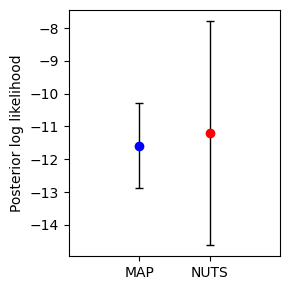

MAP: -11.5801109790802 1.310730283274242
NUTS: -11.202543 3.4151528


In [23]:
map_log_likelihood = [
    -9.865070343017578,
    -10.751142501831055,
    -10.868415832519531,
    -13.235424041748047,
    -10.996277809143066,
    -10.228208541870117,
    -13.128461837768555,
    -12.265609741210938,
    -9.890976905822754,
    -11.939689636230469,
    -15.453397750854492,
    -11.774103164672852,
    -12.111454963684082,
    -10.86875057220459,
    -10.936691284179688,
    -12.396835327148438,
    -11.09447956085205,
    -11.50871753692627,
    -10.81363296508789,
    -11.474879264831543,
]


# mcmc_log_likelihood = [tensor.to_numpy() for tensor in test_loglikelihoods]
fig, ax = plt.subplots(figsize=(3, 3))
ax.errorbar(
    1,
    np.mean(map_log_likelihood),
    yerr=np.std(map_log_likelihood, ddof=1),
    ecolor="k",
    capsize=3,
    elinewidth=1,
    color="b",
    fmt="o",
)
ax.errorbar(
    2,
    np.mean(test_loglikelihoods),
    yerr=np.std(test_loglikelihoods, ddof=1),
    ecolor="k",
    capsize=3,
    elinewidth=1,
    color="r",
    fmt="o",
)
ax.set_xticks([1, 2], ["MAP", "NUTS"])
ax.set_xlim(0, 3)
ax.set(ylabel="Posterior log likelihood")
plt.tight_layout()
plt.savefig("B1_loglikelihood_comp.png", dpi=400)
plt.show()
print("MAP:", np.mean(map_log_likelihood), np.std(map_log_likelihood, ddof=1))
print("NUTS:", np.mean(test_loglikelihoods), np.std(test_loglikelihoods, ddof=1))
